In [94]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

# Manually compute the components of a GRU cell

In [95]:
# Define input and hidden state sizes
n_features = 2
hidden_dim = 2

In [96]:
# Initialize GRU cell
torch.manual_seed(17)
gru_cell = nn.GRUCell(input_size=n_features, hidden_size=hidden_dim)
gru_state = gru_cell.state_dict()
gru_state

OrderedDict([('weight_ih',
              tensor([[-0.0930,  0.0497],
                      [ 0.4670, -0.5319],
                      [-0.6656,  0.0699],
                      [-0.1662,  0.0654],
                      [-0.0449, -0.6828],
                      [-0.6769, -0.1889]])),
             ('weight_hh',
              tensor([[-0.4167, -0.4352],
                      [-0.2060, -0.3989],
                      [-0.7070, -0.5083],
                      [ 0.1418,  0.0930],
                      [-0.5729, -0.5700],
                      [-0.1818, -0.6691]])),
             ('bias_ih',
              tensor([-0.4316,  0.4019,  0.1222, -0.4647, -0.5578,  0.4493])),
             ('bias_hh',
              tensor([-0.6800,  0.4422, -0.3559, -0.0279,  0.6553,  0.2918]))])

In [97]:
Wx, bx = gru_state['weight_ih'], gru_state['bias_ih']
Wh, bh = gru_state['weight_hh'], gru_state['bias_hh']
print(Wx.shape, Wh.shape)
print(bx.shape, bh.shape)

torch.Size([6, 2]) torch.Size([6, 2])
torch.Size([6]) torch.Size([6])


In [98]:
# Split weights and biases for reset gate (r), update gate (z), and candidate hidden state (n)
Wxr, Wxz, Wxn = Wx.split(hidden_dim, dim=0)
bxr, bxz, bxn = bx.split(hidden_dim, dim=0)
Whr, Whz, Whn = Wh.split(hidden_dim, dim=0)
bhr, bhz, bhn = bh.split(hidden_dim, dim=0)

In [99]:
# Define linear layers for each gate and the candidate state
def linear_layers(Wx, bx, Wh, bh):
    hidden_dim, n_features = Wx.size()
    lin_input = nn.Linear(n_features, hidden_dim)
    lin_input.load_state_dict({'weight': Wx, 'bias': bx})
    lin_hidden = nn.Linear(hidden_dim, hidden_dim)
    lin_hidden.load_state_dict({'weight': Wh, 'bias': bh})
    return lin_hidden, lin_input

In [100]:
# Create linear layers for reset gate, update gate, and candidate hidden state
r_hidden, r_input = linear_layers(Wxr, bxr, Whr, bhr)
z_hidden, z_input = linear_layers(Wxz, bxz, Whz, bhz)
n_hidden, n_input = linear_layers(Wxn, bxn, Whn, bhn)

In [101]:
# Define functions for each gate and the candidate hidden state
def reset_gate(h, x):
    thr = r_hidden(h)
    txr = r_input(x)
    r = torch.sigmoid(thr + txr)
    return r

def update_gate(h, x):
    thz = z_hidden(h)
    txz = z_input(x)
    z = torch.sigmoid(thz + txz)
    return z

def candidate_n(h, x, r):
    thn = n_hidden(h)
    txn = n_input(x)
    n = torch.tanh(r * thn + txn)
    return n

In [102]:
# Initial hidden state and first input
initial_hidden = torch.zeros(1, hidden_dim)
first_corner = torch.tensor([[0.1, 0.2]], dtype=torch.float32)

# Calculate reset gate (r), candidate hidden state (n), and update gate (z)
r = reset_gate(initial_hidden, first_corner)
n = candidate_n(initial_hidden, first_corner, r)
z = update_gate(initial_hidden, first_corner)

# Calculate final hidden state (h_prime)
h_prime = n * (1 - z) + initial_hidden * z

print(f"Reset gate (r): {r}")
print(f"Candidate hidden state (n): {n}")
print(f"Update gate (z): {z}")
print(f"Final hidden state (h_prime): {h_prime}")

# Verify with PyTorch GRU cell
output = gru_cell(first_corner, initial_hidden)
print(f"Output from GRU cell: {output}")

Reset gate (r): tensor([[0.2477, 0.6866]], grad_fn=<SigmoidBackward0>)
Candidate hidden state (n): tensor([[-0.4904,  0.4961]], grad_fn=<TanhBackward0>)
Update gate (z): tensor([[0.4289, 0.3784]], grad_fn=<SigmoidBackward0>)
Final hidden state (h_prime): tensor([[-0.2800,  0.3084]], grad_fn=<AddBackward0>)
Output from GRU cell: tensor([[-0.2800,  0.3084]], grad_fn=<AddBackward0>)


# GRU

In [103]:
# Generate synthetic data
def generate_sequences(seed, num_sequences=100, seq_length=10, num_features=1):
    torch.manual_seed(seed)
    sequences = torch.randn(num_sequences, seq_length, num_features)
    labels = (sequences.mean(dim=1) > 0).float().view(-1, 1)  # Simple rule: label 1 if mean > 0, else 0
    return sequences, labels

In [104]:
train_sequences, train_labels = generate_sequences(seed=19)
test_sequences, test_labels = generate_sequences(seed=42)

In [105]:
train_data = TensorDataset(train_sequences, train_labels)
test_data = TensorDataset(test_sequences, test_labels)

In [106]:
train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
test_loader = DataLoader(test_data, batch_size=16)

# GRU Model

In [107]:
class GRUModel(nn.Module):
    
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(GRUModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out,_ = self.gru(x,h0)
        out = self.fc(out[:, -1, :])  # Take the output from the last time step
        return out

In [108]:
# Model instance
input_size = 1
hidden_size = 32
output_size = 1
num_layers = 1

model = GRUModel(input_size, hidden_size, output_size, num_layers)

In [109]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [110]:
def train(model, train_loader, loss_fn, optimizer, epochs=10):
    model.train()
    train_losses = []
    for epoch in range(epochs):
        epoch_loss = 0
        for sequences, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(sequences)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        avg_loss = epoch_loss / len(train_loader)
        train_losses.append(avg_loss)
        print(f'Epoch {epoch+1}, Training Loss: {avg_loss:.4f}')
    return train_losses

In [111]:
# train_losses = train(model, train_loader, loss_fn, optimizer, epochs=100)

In [112]:
def evaluate(model, test_loader, loss_fn):
    model.eval()
    epoch_val_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for sequences, labels in test_loader:
            outputs = model(sequences)
            loss = loss_fn(outputs, labels)
            epoch_val_loss += loss.item()
            predicted = (torch.sigmoid(outputs) > 0.5).float()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    avg_val_loss = epoch_val_loss / len(test_loader)
    accuracy = correct / total
    print(f'Validation Loss: {avg_val_loss:.4f}, Accuracy: {accuracy * 100:.2f}%')
    return avg_val_loss, accuracy

In [113]:
train_losses = []
val_losses = []
epochs = 100
for epoch in range(epochs):
    train_loss = train(model, train_loader, loss_fn, optimizer, epochs=1)
    val_loss, val_accuracy = evaluate(model, test_loader, loss_fn)
    
    train_losses.extend(train_loss)
    val_losses.append(val_loss)

Epoch 1, Training Loss: 0.6842
Validation Loss: 0.6372, Accuracy: 70.00%
Epoch 1, Training Loss: 0.5693
Validation Loss: 0.4345, Accuracy: 93.00%
Epoch 1, Training Loss: 0.3328
Validation Loss: 0.3802, Accuracy: 84.00%
Epoch 1, Training Loss: 0.2772
Validation Loss: 0.2073, Accuracy: 97.00%
Epoch 1, Training Loss: 0.1647
Validation Loss: 0.1589, Accuracy: 90.00%
Epoch 1, Training Loss: 0.1640
Validation Loss: 0.1427, Accuracy: 94.00%
Epoch 1, Training Loss: 0.1184
Validation Loss: 0.1567, Accuracy: 90.00%
Epoch 1, Training Loss: 0.1225
Validation Loss: 0.1375, Accuracy: 95.00%
Epoch 1, Training Loss: 0.1553
Validation Loss: 0.1186, Accuracy: 94.00%
Epoch 1, Training Loss: 0.1360
Validation Loss: 0.1477, Accuracy: 90.00%
Epoch 1, Training Loss: 0.1199
Validation Loss: 0.0833, Accuracy: 98.00%
Epoch 1, Training Loss: 0.0899
Validation Loss: 0.0959, Accuracy: 95.00%
Epoch 1, Training Loss: 0.1040
Validation Loss: 0.0958, Accuracy: 95.00%
Epoch 1, Training Loss: 0.0799
Validation Loss: 0.0

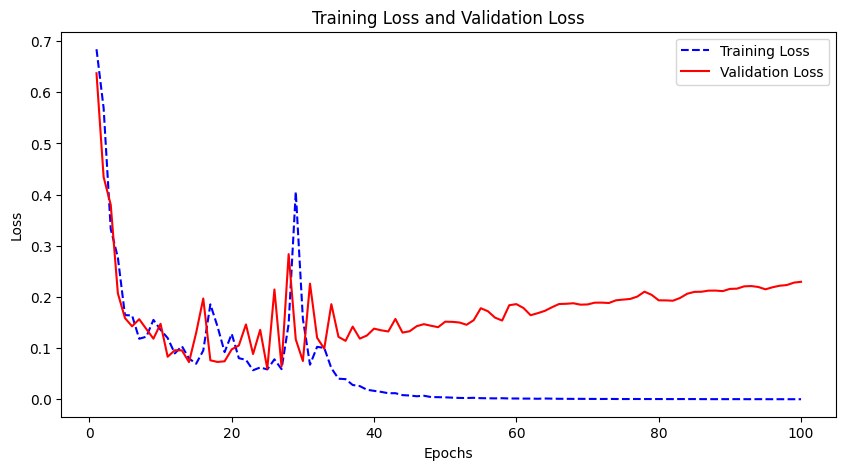

In [114]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), train_losses, label='Training Loss', linestyle='--', color='b')
plt.plot(range(1, epochs + 1), val_losses, label='Validation Loss', linestyle='-', color='r')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss and Validation Loss')
plt.legend()
plt.show()

# Prediction

In [115]:
def predict(model, input_sequence):
    model.eval()
    with torch.no_grad():
        output = model(input_sequence)
        prediction = (torch.sigmoid(output) > 0.5).float()
    return prediction

sample_sequence = torch.tensor([[[0.1], [0.2], [0.3], [0.4], [0.5], [0.6], [0.7], [0.8], [0.9], [1.0]]])
predicted_label = predict(model, sample_sequence)
print(f'Predicted Label: {predicted_label.item()}')

Predicted Label: 1.0
